In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['Kaiti']
plt.rcParams['axes.unicode_minus'] = False

![](./user信息表.PNG)
![](./login信息表.PNG)
![](./study_infomation信息表.PNG)

### 任务 1.1 对照附录 1，理解各字段的含义，进行缺失值、重复值等方面的必要处理


In [3]:
# 读取user表、login表、study_infomation表
user = pd.read_csv('./users.csv',encoding='gbk')
login = pd.read_csv('./login.csv',encoding='gbk')
study_infomation = pd.read_csv('./study_information.csv',encoding='gbk')

In [4]:
# 查看user表信息,存在两行含有空值，school列有很多的空值
# user.info()
# user.isnull()

# 查看study_infomation表的信息,price列含有空值
# study_infomation.info()

# 查看login表信息, 不存在空值
# login.info()

In [5]:
# 进行缺失值、重复值处理

# 查看user_id是否有重复值,无重复值
user[user.user_id.duplicated()]

# 删除末尾两行
new_user = user.drop(index=user.iloc[[-2,-1]].index)

# 删除school列，对之后分析无作用，且空值太多
new_user = new_user.drop(columns='school')

# 对login表按照user_id去重，保留第一个
# new_login = login.drop_duplicates(subset=['user_id','login_place'])

# 对study_infomation表以user_id、course_id进行重复值查询，无重复值
study_infomation.duplicated(subset=['user_id','course_id'])

# 对study_infomation的price列的空值进行填补
temp = study_infomation[study_infomation.price.isnull()]['course_id'].unique()   # 查看是哪些课程的price列为空

# 查看对应课程的price列是否存在不是空值，如果存在，则使用该值填补，否则就使用0填补
# for i in range(temp.size):
#     print(study_infomation[study_infomation.course_id==temp[i]].price.unique())
study_infomation.price.fillna(0,inplace=True)

### 任务 1.2 对用户信息表中 recently_logged 字段的“--”值进行必要的处理

In [6]:
new_sinfo = study_infomation[study_infomation.columns]

In [7]:
# 使用注册时间填补最近登录时间是--的
new_user[new_user.recently_logged=='--']  #11

new_user.recently_logged.mask(new_user.recently_logged=='--', new_user.register_time, inplace=True)

### 任务 2.1 分别绘制各省份与各城市平台登录次数热力地图，并分析用户分布情况。

In [8]:
# 把不属于中国的找出来
temp = login[~login['login_place'].str.contains('中国')]
# 按照索引删除非中国的行
temp = login.drop(index=temp.index)
# 查询是否有黑龙江、内蒙古的
temp[temp.login_place.str.contains('黑龙江')]
temp[temp.login_place.str.contains('内蒙古')]

# 将temp(login表)添加两列省、市，起始值为空值
temp['省'] = np.nan
temp['市'] = np.nan

# 将黑龙江、内蒙古单独进行省市的添加
temp.省.mask(temp.login_place.str.contains('黑龙江'),'黑龙江', inplace=True)
temp.省.mask(temp.login_place.str.contains('内蒙古'),'内蒙古', inplace=True)
# 正常根据截取填入省
temp.省.mask(temp.省.isnull(),temp.login_place.str[2:4],inplace=True)

# 将黑龙江，内蒙古单独填
temp.市.mask((temp.省=='黑龙江') & (temp.login_place.str.len() > 5),temp.login_place.str[5:],inplace=True)
temp.市.mask((temp.省=='内蒙古') & (temp.login_place.str.len() > 5),temp.login_place.str[5:],inplace=True)

temp.市.mask((temp.login_place.str.len()>4)&(~temp.login_place.str.contains('黑龙江'))&\
            (~temp.login_place.str.contains('内蒙古')), temp.login_place.str[4:],inplace=True)


In [9]:
# 总体数据，登录地址含有中国，所有省市有空值的
# 根据id和省市去除重复值
temp1 = temp.drop_duplicates(subset=['user_id','省','市'])
province = temp1.省.value_counts()
city = temp1.市.value_counts()


### 任务 2.2 分别绘制工作日与非工作日各时段的用户登录次数柱状图，并分析用户活跃的主要时间段。

In [10]:
# login.info()

temp.login_time = pd.to_datetime(temp.login_time)

# 星期一是1，星期日是0
temp['weekday'] = (temp.login_time.dt.weekday+1) % 7
# 将时间分段，30分钟一段
temp['time'] = temp.login_time.dt.floor('30T')

# 工作日时间段
weekday_time = temp[(temp.weekday != 6) & (temp.weekday != 0)]
# 非工作日时间段
weekend_time = temp[(temp.weekday == 6) | (temp.weekday == 0)]
weekday_time['hour'] = weekday_time.time.dt.time
weekend_time['hour'] = weekend_time.time.dt.time

# weekday_time.hour.apply(np.str)
# weekend_time.hour.apply(np.str)

<ipython-input-10-00f8d921db34>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_time['hour'] = weekday_time.time.dt.time
<ipython-input-10-00f8d921db34>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_time['hour'] = weekend_time.time.dt.time


In [11]:
# 工作日
time1_counts = pd.pivot_table(weekday_time,index='hour',values='user_id',aggfunc='count')

# 非工作日
time2_counts = pd.pivot_table(weekend_time,index='hour',values='user_id',aggfunc='count')

In [12]:
time1_counts = time1_counts.reset_index()
time2_counts = time2_counts.reset_index()

x1 = time1_counts.hour.apply(str).values.tolist()
y1 = time1_counts.user_id.values.tolist()

x2 = time2_counts.hour.apply(str).values.tolist()
y2 = time2_counts.user_id.values.tolist()

In [13]:
from pyecharts import options as opts
from pyecharts.charts import Bar
# from pyecharts.faker import Faker


c = (
    Bar()
    .add_xaxis(x1)
    .add_yaxis("",y1)  
    .set_global_opts(title_opts=opts.TitleOpts(title="工作日各时间段的登陆次数"),
        datazoom_opts=[opts.DataZoomOpts(), opts.DataZoomOpts(type_="inside")])
    
    .render_notebook()
)
c

In [14]:
from pyecharts import options as opts
from pyecharts.charts import Bar
# from pyecharts.faker import Faker


c = (
    Bar()
    .add_xaxis(x2)
    .add_yaxis("",y2)  
    .set_global_opts(title_opts=opts.TitleOpts(title="非工作日各时间段的登陆次数"),
        datazoom_opts=[opts.DataZoomOpts(), opts.DataZoomOpts(type_="inside")])
    
    .render_notebook()
)
c

### 任务 2.3 记𝑇end为数据观察窗口截止时间（如：赛题数据的采集截止时间为
### 2020 年 6 月 18 日），𝑇𝑖为用户 i 的最近访问时间，𝜎𝑖 = 𝑇end − 𝑇𝑖，若𝜎i > 90天，
### 则称用户 i 为流失用户。根据该定义计算平台用户的流失率。

In [15]:
new_user.head()
new_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43909 entries, 0 to 43908
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 43908 non-null  object 
 1   register_time           43909 non-null  object 
 2   recently_logged         43909 non-null  object 
 3   number_of_classes_join  43909 non-null  float64
 4   number_of_classes_out   43909 non-null  float64
 5   learn_time              43909 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.3+ MB


In [16]:
# pd.to_datetime('2020-6-18') - pd.to_datetime(new_user.recently_logged)
temp = (pd.to_datetime('2020-6-18 23:59:59') - pd.to_datetime(new_user.recently_logged))
temp = temp.dt.days

new_user['days'] = temp


# 流失率

In [17]:
# 流失率
np.round(new_user[new_user.days>90].index.size / new_user.index.size , 4)

0.5844

任务 3.1 根据用户参与学习的记录，统计每门课程的参与人数，计算每门课
程的受欢迎程度，列出最受欢迎的前 10 门课程，并绘制相应的柱状图。受欢迎
程度定义如下：  
𝛾𝑖 = 𝑄𝑖 − 𝑄min / 𝑄max− 𝑄min  
其中，𝛾𝑖为第 i 门课程的受欢迎程度，𝑄𝑖为参与第 i 门课程学习的人数，𝑄max
和𝑄min分别为所有课程中参与人数最多和最少的课程所对应的人数。


In [18]:
# 查看根据user_id,course_id是否存在重复值————不存在
new_sinfo[new_sinfo[['user_id','course_id']].duplicated()]

,user_id,course_id,course_join_time,learn_process,price


In [19]:
# 统计每门课程的选课人数
change = new_sinfo['course_id'].value_counts()
course_counts = new_sinfo['course_id'].value_counts().nlargest(10)
# 根据所给公式，计算受欢迎程度前十的课程
popularity = ((change - change.min()) / (change.max() - change.min())).nlargest(10)


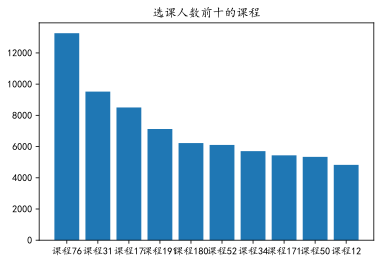

In [20]:
# 绘制选课人数前十的课程柱状图

plt.bar(course_counts.index, course_counts)
plt.title('选课人数前十的课程')
plt.show()

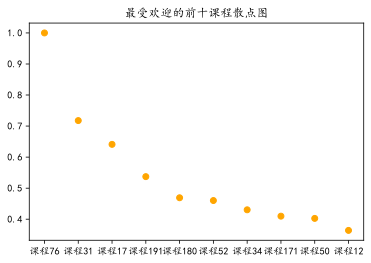

In [21]:
# 最受欢迎的前十课程
plt.scatter(popularity.index, popularity, c = 'orange')
plt.title('最受欢迎的前十课程散点图')
plt.show()

##### 任务 3.2 根据用户选择课程情况，构建用户和课程的关系表（二元矩阵），使用基于物品的协同过滤算法计算课程之间的相似度，并结合用户已选课程的记录，为总学习进度最高的 5 名用户推荐 3 门课程。

In [22]:
# 数据准备
user_course = new_sinfo[['user_id','course_id']]

In [23]:
# 重塑数据, 构建二维矩阵
pivot_data= pd.pivot(user_course, index='course_id', columns='user_id', values='course_id')

# 将有值的更换为1
pivot_data.mask(~pivot_data.isnull(),1,inplace=True)
# 将空值换为0
pivot_data.fillna(0, inplace=True)
pivot_data

user_id,用户10,用户100,用户10000,用户10001,用户10002,用户10003,用户10004,用户10005,用户10006,用户10007,...,用户9989,用户999,用户9990,用户9991,用户9992,用户9993,用户9994,用户9995,用户9996,用户9999
course_id,,,,,,,,,,,,,,,,,,,,,
课程0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
课程1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
课程10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
课程100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
课程101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
课程95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
课程96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
课程97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

In [25]:
# cosine_similarity(pivot_data)

In [26]:
# 计算相似性矩阵
cor_score = np.corrcoef(pivot_data)

In [27]:
# 构建相似性矩阵的DataFrame
sim_m = pd.DataFrame(data=cor_score, columns=pivot_data.index, index=pivot_data.index)

In [58]:
sim_course = sim_m[sim_m['课程0']>0]['课程0'].nlargest(len(sim_m['课程0']))
sim_course

course_id
课程0      1.000000
课程9      1.000000
课程103    1.000000
课程104    1.000000
课程41     1.000000
           ...   
课程17     0.013644
课程31     0.012691
课程76     0.010088
课程40     0.009442
课程12     0.008272
Name: 课程0, Length: 117, dtype: float64

In [30]:
# 统一学习进度列的数据格式

# 替换，转类型：只能运行一次，成功之后再次运行会报错
new_sinfo.learn_process = new_sinfo.learn_process.str.replace('width:', '')
new_sinfo.learn_process = new_sinfo.learn_process.str.replace('%', '')
new_sinfo.learn_process = new_sinfo.learn_process.str.replace(';', '')

new_sinfo.learn_process = new_sinfo.learn_process.apply(int)



In [40]:
# 统计总学习进度，取前五名
width = pd.pivot_table(new_sinfo, index='user_id', values='learn_process', aggfunc='sum').nlargest(5, columns='learn_process')

In [41]:
width

,learn_process
user_id,
用户1193,5238
用户13841,4042
用户32684,3291
用户36989,2960
用户24985,2951


In [57]:
# 将学习进度前五的人筛选出来，并统计他们选的课程，以字典形式保存
courses = {}
for name in width.index:
    courses[f'{name}'] = new_sinfo[new_sinfo.user_id == name]['course_id'].values.tolist()


In [59]:
# 相似课程
sim_course = sim_course.index.to_list()

In [60]:
for i in courses.keys():
    temp_course = sim_course[:]
    for name in temp_course:
        if name in courses.get(i):
            temp_course.remove(name)
    print(f'给{i}推荐课程：{temp_course[:3]}')

给用户1193推荐课程：['课程0', '课程9', '课程103']
给用户13841推荐课程：['课程0', '课程9', '课程103']
给用户32684推荐课程：['课程0', '课程9', '课程103']
给用户36989推荐课程：['课程0', '课程9', '课程103']
给用户24985推荐课程：['课程0', '课程9', '课程103']
